In [ ]:
co#Mount drive to access the data
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/EPFL HS21/Machine Learning CS-433/projects/ML team project/Project 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/EPFL HS21/Machine Learning CS-433/projects/ML team project/Project 2


In [ ]:
#Paths to data for easy access
folder_path_full = "extracted_droplets_reduced_radius"
folder_path_sample = "extracted_droplets_sample"
folder_path_destination = "labelling_test"
folder_path_all_droplets = "extracted_droplets_new_subset"
folder_path_unlabelled = "droplets_unlabelled"
folder_path_labelled = "droplets_labelled"

### Helper functions

In [ ]:
!pip install scikit-learn-extra

In [ ]:
import sys, os
import pickle
import numpy as np
import pandas as pd
import skimage.color
import skimage.io
import skimage.measure
import shutil
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import confusion_matrix

In [ ]:
def get_all_filenames_in_folder(folder_path):
  #returns only files, not folders
  return [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]


In [ ]:
def load_image(file_path):
  image = skimage.io.imread(fname=file_path, as_gray=True)
  return image

In [ ]:
def standardize_matrix(matrix):
   return (matrix - np.mean(matrix)) / np.std(matrix)

In [ ]:
def get_image_std(image):
  image = image[image != 0] #renove ure black (0) pixels
  image = image[image != 255] #remove pure white (255) pixels
  return image.std()

def preprocess_image(image, standardize=False):
  image = skimage.measure.block_reduce(image, (2,2), np.min) #min pooling to accentuate dark items
  image = image[image != 0] #renove pure black (0) pixels
  image = image[image > 30] #renove dark pixels that are less than 20 (very dark colours that are likely shadows)
  image = image[image <= 240] #remove pure white (255) pixels
  if standardize:
    image = image-np.median(image)
    image = standardize_matrix(image)
  else: pass
  return image.ravel()

def preprocess_image_secondary_split(image, quantile=10):
  image = skimage.measure.block_reduce(image, (2,2), np.max) #min pooling to accentuate dark items
  image = image[image != 0] #renove pure black (0) pixels
  image = image[image > 30] #renove dark pixels that are less than 20 (very dark colours that are likely shadows)
  image = image[image <= 240] #remove pure white (255) pixels
  median_norm = image-np.median(image)
  standard_median_norm = standardize_matrix(median_norm)
  metric = np.percentile(standard_median_norm, q=quantile) - np.median(standard_median_norm)
  return metric.ravel()

def bincount(a):
    y = np.bincount(a)
    ii = np.nonzero(y)[0]
    return np.vstack((ii, y[ii])).T

In [ ]:
def list_files_in_subdirs(dir):                                                                                                  
    r = []                                                                                                       
    subdirs = [x[0] for x in os.walk(dir)]                                                                           
    for subdir in subdirs:                                                                                            
        files = get_all_filenames_in_folder(subdir)                                                                            
        if (len(files) > 0):                                                                                          
            for file in files:                                                                                        
                r.append(os.path.join(subdir, file))                                                                         
    return r 

In [ ]:
#make list of pixel matrices (one for each image)
def get_image_from_folder(folder_path, return_labels = False):
  #folder_path -> the path of the folder on which the images have to be classified
  list_of_file_names = get_all_filenames_in_folder(folder_path) #list_files_in_subdirs(folder_path)
  list_of_image_matrices = []
  list_of_image_labels = []
  for file_name in list_of_file_names: #iterate through all the files in the specified folder
    #load image
    image = load_image(os.path.join(folder_path, file_name))
    label = file_name[0]

    list_of_image_matrices.append(image)
    list_of_image_labels.append(int(label))
  if return_labels == True:
    return list_of_image_matrices, list_of_image_labels #a list of array of shape (image_shape), list of labels
  else:
    return list_of_image_matrices

In [ ]:
#get image and labels for the 1k labelled randomly selected sample
#images, labels = get_image_from_folder(folder_path_labelled, return_labels = True)

#save the arrays for further use
#np.save('droplets_labelled_matrices.npy', images)
#np.save('droplets_labelled_labels.npy', labels)

### Multifeature approach (Benchmark)

In this approach we first analyse the 1000 labelled images and retrieve several feature from them. All the features are collected into a table and are then fed into several unsupervised (KMedoids) and supervised (DecisionTreeClassifier) from the SKlearn library.

The results for both benchmark trials are not conclusive and show that the fully unsupervised approach based on the intercluster distance metric works better in terms of accuracy.

Further research could focus on creating a larger labelled dataset that could improve the overall accuracy of the supervised model.

The models are taken from the SkLearn library.



#### Supervised DecisionTreeClassifier model

In [ ]:
def get_image_selected_feature(image):
  image = preprocess_image(image, standardize=True)

  mean_colour = image.mean()
  median_colour = np.median(image)
  colour_percentile_10 = np.percentile(image, q=10)
  colour_percentile_20 = np.percentile(image, q=20)
  colour_percentile_30 = np.percentile(image, q=30)
  colour_percentile_40 = np.percentile(image, q=40)
  colour_percentile_50 = np.percentile(image, q=50)
  colour_percentile_60 = np.percentile(image, q=60)
  colour_percentile_70 = np.percentile(image, q=70)
  colour_percentile_80 = np.percentile(image, q=80)
  colour_percentile_90 = np.percentile(image, q=90)
  colour_percentile_60_median_norm = np.percentile(image, q=60) - np.median(image)
  colour_percentile_70_median_norm = np.percentile(image, q=70) - np.median(image)
  colour_percentile_80_median_norm = np.percentile(image, q=80) - np.median(image)
  colour_percentile_90_median_norm = np.percentile(image, q=90) - np.median(image)

  selected_features = [
        median_colour, 
        colour_percentile_10, 
        colour_percentile_20, 
        colour_percentile_30, 
        colour_percentile_40, 
        colour_percentile_50, 
        colour_percentile_60, 
        colour_percentile_70, 
        colour_percentile_80, 
        colour_percentile_90, 
        colour_percentile_60_median_norm, 
        colour_percentile_70_median_norm, 
        colour_percentile_80_median_norm, 
        colour_percentile_90_median_norm]

  return selected_features

#creating an empty dataframe to store the image characteristics
column_names = [
    'median_colour',
    'colour_percentile_10',
    'colour_percentile_20',
    'colour_percentile_30',
    'colour_percentile_40',
    'colour_percentile_50',
    'colour_percentile_60',
    'colour_percentile_70',
    'colour_percentile_80',
    'colour_percentile_90',
    'colour_percentile_60_median_norm',
    'colour_percentile_70_median_norm',
    'colour_percentile_80_median_norm',
    'colour_percentile_90_median_norm']
image_features = pd.DataFrame(columns = column_names)

#getting the selected image features for each image
for image in images:
  row = get_image_selected_feature(image)
  image_features.loc[len(image_features)] = row

total observations:  700
accuracy:  0.8114285714285714
precision:  0.9135338345864662
recall:  0.6903409090909091
[[325  23]
 [109 243]]
total observations:  300
accuracy:  0.7366666666666667
precision:  0.8671875
recall:  0.6416184971098265
[[110  17]
 [ 62 111]]
total observations:  700
accuracy:  0.91
precision:  0.9135338345864662
recall:  0.8586572438162544
[[394  23]
 [ 40 243]]
total observations:  300
accuracy:  0.85
precision:  0.8515625
recall:  0.8074074074074075
[[146  19]
 [ 26 109]]
total observations:  700
accuracy:  0.9471428571428572
precision:  0.9962406015037594
recall:  0.8803986710963455
[[398   1]
 [ 36 265]]
total observations:  300
accuracy:  0.92
precision:  0.96875
recall:  0.8611111111111112
[[152   4]
 [ 20 124]]
total observations:  700
accuracy:  0.9728571428571429
precision:  1.0
recall:  0.9333333333333333
[[415   0]
 [ 19 266]]
total observations:  300
accuracy:  0.9433333333333334
precision:  0.96875
recall:  0.9051094890510949
[[159   4]
 [ 13 124]]
t

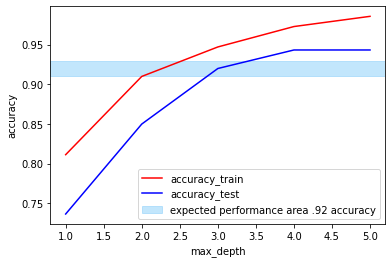

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split

accuracy_train_acc = []
accuracy_test_acc = []
max_depth = []

#slit data in train and test set
X_train, X_test, y_train, y_test = train_test_split(image_features, labels, test_size=0.30, random_state=123)

for tree_depth in range(1,6):
  #train model
  clf = tree.DecisionTreeClassifier(max_depth=tree_depth, random_state=123)
  clf.fit(X_train, y_train)
  predictions_train = clf.predict(X_train)
  cm, accuracy_train = make_confusion_matrix(predictions_train, y_train)

  #test model
  predictions_test = clf.predict(X_test)
  cm, accuracy_test = make_confusion_matrix(predictions_test, y_test)

  #accumulate data
  accuracy_train_acc.append(accuracy_train)
  accuracy_test_acc.append(accuracy_test)
  max_depth.append(tree_depth)

#plot the results
plt.plot(max_depth, accuracy_train_acc, label = "accuracy_train", color = 'red')
plt.plot(max_depth, accuracy_test_acc, label = "accuracy_test", color = 'blue')
plt.axhspan(.91, .93, alpha=0.5, label="expected performance area .92 accuracy", color='lightskyblue') #axhline(y=0.91, color="lightskyblue")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()

#### Supervised approach with Kmedoids (with multi-feature metrics)

The result is non conclusive. There is a higher precision and lower recall than with the fully unsupervised approach with intercluster distance metric. 

The accuracy of the multi-feature unsupervised KMedoid model (0.724) is lower than the single metric models (both kmeans and Kmedoids).

In [ ]:
multi_feature_model = KMedoids(n_clusters=2, random_state=123)
multi_feature_model.fit(image_features)
model_centroids = multi_feature_model.cluster_centers_.ravel().tolist()
centroid_difference = max(model_centroids) - min(model_centroids)

predictions = multi_feature_model.predict(image_features)

make_confusion_matrix(predictions, labels)

total observations:  1000
accuracy:  0.724
precision:  0.9720812182741116
recall:  0.5910493827160493
[[341  11]
 [265 383]]


(array([[341,  11],
        [265, 383]]), 0.724)

In [ ]:
#load saved array to speed up image processing
images = np.load("droplets_labelled_matrices.npy", allow_pickle=True)
labels = np.load("droplets_labelled_labels.npy", allow_pickle=True)

print("Length of labelled set: ", len(labels))

Length of labelled set:  1000


## InterCluster Distance Metric (ICD) approach

The following models follow the ICD approach developped internally by our team. The problem we are facing is FULLY UNSUPERVISED.

The approach consider a single metric for image classification, the ICD.
For each individual preprocessed images, we will train a 2-cluster model in order to classify in 2 group the preprocessed pixels of that image. We then compute the intercluster distance and infer that if the ICD metric is low, then the droplets are empty and if the ICD metric is large, then it means that the droplet is full since there are both dark (cell activty) and light (background) coloured pixels in the same image.

Once all the ICD metric collected, we run a second 2-cluster clustering model (Kmeans, Kmedoids and Gaussian mixture models tried) that will cluster the ICD metric in 2 groups. This will bring us the definition of what is "low" and "high" intercluster distance. This model is run on all the ICD metrics (not only on a single image since it would only be 1 metric then).

The results are very conclusive. The KMedoid model, rebust to outliers, obtain the following best scores:
- accuracy:  0.913
- precision:  0.9593908629441624
- recall:  0.8418708240534521

The KMedoids model is retained. Gaussian misture and Kmeans models are not robust enough to outliers. The models offer also slower model speed performanced than the Kmedoid model. 




### Classification stage 1 (initial classification)

This section will train and then use a global model (shared across all image of all microscope pictures).
It will make a first prediction on wether the images are in class 1 or 0.

### 1.1.2 Making intial predictions (with a trained and saved model that we re-load to make predictions)

#### This code predicts for the **Initial KMedoids and Kmeans** approaches

In [ ]:
# CLASSIFICATION STAGE 1 (using the pre-trained model)

# The "initial split" that will determine if the images belong to either:
# 0. empty droplets
# 1. full droplets OR empty droplets with noise (will have to be futher classified for robustness to noise)
def get_initial_prediction_split_pretrained(images, approach = "KMedoids"):
  centroid_difference_acc = np.array([])
  initial_predictions = np.array([])
  for image in images:
    #processs image
    preprocessed_image = preprocess_image(image).reshape(-1, 1)

    #initialize model 2 clusters
    individual_model = KMeans(n_clusters=2, random_state=123)

    #train model 2 clusters
    individual_model.fit(preprocessed_image)

    #get model centroids information
    model_centroids = individual_model.cluster_centers_.ravel().tolist()
    centroid_difference = max(model_centroids) - min(model_centroids)
    centroid_difference_acc = np.append(centroid_difference_acc, centroid_difference) #accumulate all centroids in an array to cluster them

  
  #train clustering model on the centroid_differences to find the optimal thresholds
  if approach == "KMedoids":
    initial_split_model = pickle.load(open("initial_split_model_KMedoids.pkl", "rb"))
  elif approach == "KMeans":
    initial_split_model = pickle.load(open("initial_split_model_KMeans.pkl", "rb"))
  prediction_initial_split = initial_split_model.predict(centroid_difference_acc.reshape(-1, 1))
  
  #get model cluster centers and their values
  model_centroids_initial_split = initial_split_model.cluster_centers_.ravel().tolist()
  print("Initial split model centroids (loaded model): ", model_centroids_initial_split)
  model_centroids_initial_split_min_value = min(model_centroids_initial_split)
  model_centroids_initial_split_min_class = model_centroids_initial_split.index(model_centroids_initial_split_min_value)
  model_centroids_initial_split_max_value = max(model_centroids_initial_split)
  model_centroids_initial_split_max_class = model_centroids_initial_split.index(model_centroids_initial_split_max_value)

  for pred in prediction_initial_split:
    if pred == model_centroids_initial_split_min_class:
      # intially classified empty droplets do not have to be further processed
      label = 0
    else:
      # initially classified "full" droplets have to be reprocessed for robustness to noise (done in another function)
      label = 1
    initial_predictions = np.append(initial_predictions, label)
  return initial_predictions #array of predicted labels (0=empty, 1=full or empty with noise)

#### This code predicts for the **Initial Gaussian mixture** approach

In [ ]:
# CLASSIFICATION STAGE 1 (using the pre-trained model)

# The "initial split" that will determine if the images belong to either:
# 0. empty droplets
# 1. full droplets OR empty droplets with noise (will have to be futher classified for robustness to noise)
def get_initial_prediction_split_gaussian(images):
  centroid_difference_acc = np.array([])
  initial_predictions = np.array([])
  for image in images:
    #processs image
    preprocessed_image = preprocess_image(image).reshape(-1, 1)

    #initialize model 2 clusters
    individual_model = KMeans(n_clusters=2, random_state=123)

    #train model 2 clusters
    individual_model.fit(preprocessed_image)

    #get model centroids information
    model_centroids = individual_model.cluster_centers_.ravel().tolist()
    centroid_difference = max(model_centroids) - min(model_centroids)
    centroid_difference_acc = np.append(centroid_difference_acc, centroid_difference) #accumulate all centroids in an array to cluster them

  
  #train clustering model on the centroid_differences to find the optimal thresholds
  initial_split_model = pickle.load(open("initial_split_model_gaussian.pkl", "rb")) #GAUSSIAN mixture
  prediction_initial_split = initial_split_model.predict(centroid_difference_acc.reshape(-1, 1))
  prediction_initial_split_proba = initial_split_model.predict_proba(centroid_difference_acc.reshape(-1, 1)) #[:,1]
  
  return prediction_initial_split #initial_predictions #array of predicted labels (0=empty, 1=full or empty with noise)

#### This code predicts for the **Secondary prediction** approach

In [ ]:
# CLASSIFICATION STAGE 2
# The "secondary split" that will determine if the images belong to either:
# 0. empty droplets with noise (will be labelled 0 in the end)
# 1. full droplets (will be labelled 1 in the end)
 
def get_secondary_predictions(images, initial_predictions): #list of image matrices, array of initial predictions corresponding to the images
  smallest_class_to_total_ratio_acc = np.array([])
  secondary_predictions = np.array([])
  for image, initial_prediction in zip(images, initial_predictions):
    if initial_prediction == 0: #ignore already classified negatives
      smallest_class_to_total_ratio_acc = np.append(smallest_class_to_total_ratio_acc, -1)
    else: #futher process intially classified positives
      secondary_metric = preprocess_image_secondary_split(image, quantile=10)
      smallest_class_to_total_ratio_acc = np.append(smallest_class_to_total_ratio_acc, secondary_metric)
  
  #initialize, train and predict secondary classification model
  secondary_split_model = KMeans(n_clusters=2, random_state=123) #using KMEANS or KMEDOIDS to split quantile metric of interest
  secondary_split_model.fit(smallest_class_to_total_ratio_acc[smallest_class_to_total_ratio_acc != -1].reshape(-1, 1))

  #save model (only for training)
  #pickle.dump(secondary_split_model, open("secondary_split_KMeans_split_quantile.pkl", "wb"))
  
  #load model
  secondary_split_model = pickle.load(open("secondary_split_KMeans_split_quantile.pkl", "rb"))
  
  #compute metrics of interest
  model_centroids_secondary_split = secondary_split_model.cluster_centers_.ravel().tolist()
  print("Secondary split model centroids: ", model_centroids_secondary_split)
  model_centroids_secondary_split_min_value = min(model_centroids_secondary_split)
  model_centroids_secondary_split_min_class = model_centroids_secondary_split.index(model_centroids_secondary_split_min_value)
  model_centroids_secondary_split_max_value = max(model_centroids_secondary_split)
  model_centroids_secondary_split_max_class = model_centroids_secondary_split.index(model_centroids_secondary_split_max_value)
  
  #predict with secondary model
  for initial_prediction, three_cluster_ratio_score in zip(initial_predictions, smallest_class_to_total_ratio_acc):
    if initial_prediction == 0:
      label = 0
    else:
      prediction = int(secondary_split_model.predict(three_cluster_ratio_score.reshape(-1, 1)))
      if prediction == model_centroids_secondary_split_max_class:
        label = 0
      else:
        label = 1
    secondary_predictions = np.append(secondary_predictions, label)
  
  return secondary_predictions #an ordered array of predictions
 
#secondary_predictions = get_secondary_predictions(images, initial_predictions)
#print(secondary_predictions)

## Evaluation

In this section we evaluates the different models with a labelled image set of 1000 images randomly selected from our entire image dataset to be representative of all the image qualities and categories that we have in the dataset.

In [ ]:
def make_confusion_matrix(predicted, actuals):
  cm = confusion_matrix(predicted, actuals)
  tn, fp, fn, tp = cm.ravel()
  total_observations = len(actuals)
  accuracy = (tp+tn)/total_observations
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)

  print("total observations: ", total_observations)
  print("accuracy: ", accuracy)
  print("precision: ", precision)
  print("recall: ", recall)
  print(cm)
  return cm, accuracy

def make_predictions(input_data, approach="KMedoids"):
  #make predictions
  if approach == "KMedoids":
    initial_predictions = get_initial_prediction_split_pretrained(input_data, approach = "KMedoids")
    predicted = initial_predictions
  elif approach == "KMedoids_KMeans_split_quantile":
    initial_predictions = get_initial_prediction_split_pretrained(input_data, approach = "KMedoids")
    predicted = get_secondary_predictions(input_data, initial_predictions)
  elif approach == "KMeans":
    initial_predictions = get_initial_prediction_split_pretrained(input_data, approach = "KMeans") #model to be trained
    predicted = initial_predictions
  elif approach == "GaussianMixture":
    initial_predictions = get_initial_prediction_split_gaussian(input_data)
    predicted = initial_predictions
  elif approach == "KMedoids_Kmeans_intercluster_range":
    initial_predictions = get_initial_prediction_split_pretrained(input_data)
    predicted = get_secondary_predictions(input_data, initial_predictions)
  else: pass

  return predicted

In [ ]:
# BEST PERFORMANCE
predictions_KMedoids = make_predictions(images, approach="KMedoids")
cm, accuracy = make_confusion_matrix(predictions_KMedoids, labels)

Initial split model centroids (loaded model):  [5.711734061027045, 24.512209302325573]
total observations:  1000
accuracy:  0.913
precision:  0.9593908629441624
recall:  0.8418708240534521
[[535  16]
 [ 71 378]]


In [ ]:
predictions_GaussianMixture = make_predictions(images, approach="GaussianMixture")
cm, accuracy = make_confusion_matrix(predictions_GaussianMixture, labels)

total observations:  1000
accuracy:  0.589
precision:  0.015228426395939087
recall:  0.20689655172413793
[[583 388]
 [ 23   6]]


In [ ]:
predictions_KMeans = make_predictions(images, approach="KMeans")
cm, accuracy = make_confusion_matrix(predictions_KMeans, labels)

Initial split model centroids (loaded model):  [72.40411653359088, 16.398768442285007]
total observations:  1000
accuracy:  0.588
precision:  0.015228426395939087
recall:  0.2
[[582 388]
 [ 24   6]]


In [ ]:
#Quantile metric Kmeans (individual model) and Kmedoids prediction (initial model prediction) models. 
#The 10th quantile metric is selected to use a KMEANS cluster models on secondary split model
#Non conclusive tests (Benchmark)
predictions_KMedoids_KMeans_split_quantile = make_predictions(images, approach="KMedoids_KMeans_split_quantile")
cm, accuracy = make_confusion_matrix(predictions_KMedoids_KMeans_split_quantile, labels)

#Best performance on the labelled dataset but real data shows that other models have better performance on edge cases

Initial split model centroids (loaded model):  [5.711734061027045, 24.512209302325573]
Secondary split model centroids:  [-1.3619960315569155, -0.8190035210238797]
total observations:  1000
accuracy:  0.938
precision:  0.8807106598984772
recall:  0.9585635359116023
[[591  47]
 [ 15 347]]


In [ ]:
#Quantile metric Kmeans (individual model) and Kmedoids prediction (initial model prediction) models. 
#The 10th quantile metric is selected to use a KMEDOIDS cluster models on secondary split model
#Non conclusive tests (Benchmark)
predictions_KMedoids_KMeans_split_quantile = make_predictions(images, approach="KMedoids_KMeans_split_quantile")
cm, accuracy = make_confusion_matrix(predictions_KMedoids_KMeans_split_quantile, labels)

Initial split model centroids (loaded model):  [5.711734061027045, 24.512209302325573]
Secondary split model centroids:  [-1.3619960315569155, -0.8190035210238797]
total observations:  1000
accuracy:  0.938
precision:  0.8807106598984772
recall:  0.9585635359116023
[[591  47]
 [ 15 347]]


## Various utility functions for visuliaztion and manual annotations

In [ ]:
def write_images_to_drive_for_prediction(folder_path, folder_path_destination):
  #folder_path -> the path of the folder on which the images have to be classified

  #make predictions from the images in folder_path
  images = get_image_from_folder(folder_path)
  initial_predictions = get_initial_prediction_split_pretrained(images)
  secondary_predictions = initial_predictions #get_secondary_predictions(images, initial_predictions)


  #make a copy of files into folder_path_destination for visual inspection
  list_of_file_names = get_all_filenames_in_folder(folder_path)
  counter = 0
  for file_name, prediction in zip(list_of_file_names, secondary_predictions): #iterate through all the files in the specified folder
    file_path = folder_path + "/" + file_name

    #if prediction in [0,1,2]:
      #save image
    destination_file_path = folder_path_destination + "/" + str(int(prediction)) + "_" + str(counter) + ".jpg" #str(round(prediction*1000))
    shutil.copy(file_path, destination_file_path)

    counter += 1

write_images_to_drive_for_prediction(folder_path_unlabelled, folder_path_labelled)

Initial split model centroids (loaded model):  [5.711734061027045, 24.512209302325573]



-1.5491948129615707


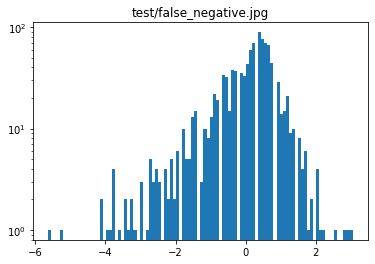

-0.9150102034264115


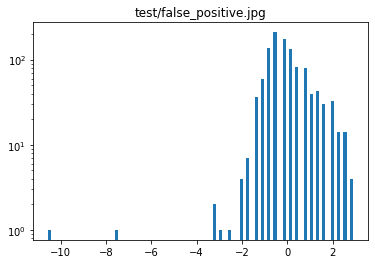

-0.4080014625290411


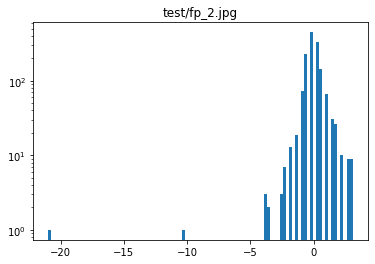

-0.6277056600229801


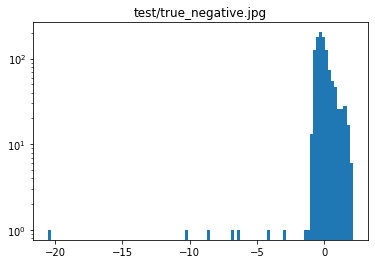

-1.3174402861713548


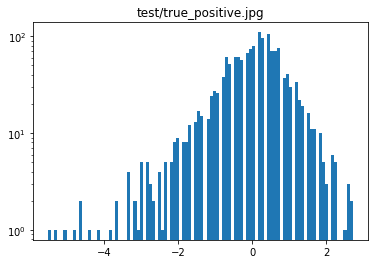

In [ ]:
#visualization of some images' pixel distrubutions for feature engineering
list_of_file_names = list_files_in_subdirs("test")
print()
for file_name in sorted(list_of_file_names):
  image = load_image(file_name)
  #image = preprocess_image_secondary_split(image)
  image = skimage.measure.block_reduce(image, (2,2), np.max) #min pooling to accentuate dark items
  image = image[image != 0] #renove pure black (0) pixels
  image = image[image > 30] #renove dark pixels that are less than 20 (very dark colours that are likely shadows)
  image = image[image <= 240] #remove pure white (255) pixels
  median_norm = image-np.median(image)
  standard_median_norm = standardize_matrix(median_norm)
  metric = np.percentile(standard_median_norm, q=10) - np.median(standard_median_norm)
  print(metric)
  plt.hist(standard_median_norm, bins=100)
  plt.title(file_name)
  plt.yscale('log')
  plt.show()